In [30]:
%matplotlib inline
from importlib import reload
import json
import sys
sys.path.append("..")
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage import io
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import cv2

import pythd

In [31]:
DATA_DIR = Path("..") / Path("data")
CHIP_SHAPE = (8, 8)
CHIP_STRIDE = (8, 8)

In [35]:
DAMAGE_LEVELS = {
    "un-classified": 1,
    "no-damage": 2,
    "minor-damage": 3,
    "major-damage": 4,
    "destroyed": 5
}

def build_chipped_df(images, chip_size=(16,16), chip_stride=(16,16)):
    dfs = []
    cw, ch = chip_size
    sx, sy = chip_stride
    
    for pre_path in tqdm(list(images)):
        pre_img = io.imread(str(pre_path))
        pre_chipped = pythd.image.ChippedImage.FromRGB(pre_img, chip_size, chip_stride)
        pre_df = pre_chipped.df
        cols = [col for col in pre_df.columns if "pixel" in col]
        pre_df.loc[:, cols] = (pre_df.loc[:, cols] - pre_df.loc[:, cols].mean(axis=0)) / pre_df.loc[:, cols].std(axis=0)
        pre_df.columns = ["pre_" + col for col in pre_df.columns]

        post_path = DATA_DIR / pre_path.name.replace("pre", "post")
        post_img = io.imread(str(post_path))
        post_chipped = pythd.image.ChippedImage.FromRGB(post_img, chip_size, chip_stride)
        post_df = post_chipped.df
        post_df.loc[:, cols] = (post_df.loc[:, cols] - post_df.loc[:, cols].mean(axis=0)) / post_df.loc[:, cols].std(axis=0)
        post_df.columns = ["post_" + col for col in post_df.columns]

        df = pd.concat((pre_df, post_df), axis=1)
        df.drop(["post_x", "post_y"], axis=1, inplace=True)
        df.rename({"pre_x": "x", "pre_y": "y"}, axis=1, inplace=True)
        df["image"] = pre_path.name
        df.astype({"x": "int32", "y": "int32"}, copy=False)
        df["building"] = 0
        df["damage"] = 1
        
        label_path = DATA_DIR / post_path.name.replace("png", "json")
        if label_path.exists():
            label_mask = np.zeros(post_img.shape[:2], dtype=np.uint8)
            with open(label_path, "r") as f:
                labels = json.load(f)
                labels = labels["features"]["xy"]
                for o in [obj for obj in labels if (obj["properties"]["feature_type"] == "building")]:
                    coords = o["wkt"][10:-2].split(', ')
                    bbox= np.array([list(map(lambda x: int(float(x)), coord.split(' '))) for coord in coords])
                    damage = DAMAGE_LEVELS[o["properties"]["subtype"]]
                    cv2.fillPoly(label_mask, [bbox], color=damage)
            
            for row in df.index:
                x = int(df.loc[row, "x"])
                y = int(df.loc[row, "y"])
                chip = label_mask[y:(y+ch), x:(x+cw)]
                df.loc[row, "building"] = int((chip > 0).any())
                df.loc[row, "damage"] = chip.max()
        dfs.append(df)
    
    dfs = pd.concat(dfs, axis=0, ignore_index=True)
    return dfs

df = build_chipped_df(list(DATA_DIR.glob("*pre_disaster.png"))[:3], chip_size=CHIP_SHAPE, chip_stride=CHIP_STRIDE)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:38<00:00, 12.69s/it]


In [36]:
features = [c for c in df.columns if "pixel" in c]
data = df.loc[:, features].values
print(df.shape)
df.head()

(49152, 389)


x    y  pre_pixel 1  pre_pixel 2  pre_pixel 3  pre_pixel 4  pre_pixel 5  \
0   0.0  0.0     1.042159     0.954475     1.272613     1.009705     0.912927   
1   8.0  0.0     1.144564     1.041460     1.411893     1.112159     1.043510   
2  16.0  0.0     0.973889     0.823997     1.226186     1.112159     0.956455   
3  24.0  0.0     1.690724     1.650358     2.108297     1.795187     1.783480   
4  32.0  0.0     1.827264     1.954807     2.294004     1.556127     1.609370   

   pre_pixel 6  pre_pixel 7  pre_pixel 8  ...  post_pixel 186  post_pixel 187  \
0     1.228572     1.149110     1.046700  ...        0.081702        0.500122   
1     1.367970     1.114930     1.003132  ...        0.651354        0.638777   
2     1.367970     1.149110     1.003132  ...        0.651354        0.846761   
3     2.250820     1.901087     1.961620  ...        0.651354        0.708105   
4     1.925559     1.456737     1.482376  ...        1.302385        0.569450   

   post_pixel 188  post_pixel 189  post_pixel 190  post_pixel 191  \
0        0.254332        0.326405        0.643969        0.398702   
1        0.469225        0.733089        0.783801        0.687501   
2        0.755748        1.058436        0.084642       -0.251095   
3        0.397594        0.733089        0.434221        0.109903   
4        0.325963        0.570415        0.504137        0.254303   

   post_pixel 192                                         image  building  \
0        0.573640  hurricane-florence_00000419_pre_disaster.png         0   
1        0.983723  hurricane-florence_00000419_pre_disaster.png         0   
2       -0.000476  hurricane-florence_00000419_pre_disaster.png         0   
3        0.409607  hurricane-florence_00000419_pre_disaster.png         0   
4        0.573640  hurricane-florence_00000419_pre_disaster.png         0   

   damage  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 389 columns]

In [37]:
#base_filt = pythd.filter.ScikitLearnFilter(PCA, n_components=200)
filt = pythd.filter.ScikitLearnFilter(PCA, n_components=2)
#data = base_filt(data)
base_filt = None
f_x = filt(data)
print(f_x.shape)

(49152, 2)


In [38]:
reload(pythd)
reload(pythd.thd)
reload(pythd.complex)
reload(pythd.cover)
reload(pythd.mapper)
reload(pythd.clustering)

clustering = pythd.clustering.HierarchicalClustering()
cover = pythd.cover.IntervalCover.EvenlySpacedFromValues(f_x, 15, 0.4)
thd = pythd.thd.THD(data, filt, cover, group_threshold=1000, contract_amount=0.4)
thd.run(verbose=True)
root = thd.get_results()

1 jobs remaining
Group 0.0.0 finished (49152 rids)
1 jobs remaining
Group 1.0.0 finished (47671 rids)
9 jobs remaining
Group 2.0.0 finished (1746 rids)
9 jobs remaining
Group 3.0.0 finished (1746 rids)
8 jobs remaining
Group 2.1.0 finished (1421 rids)
8 jobs remaining
Group 3.1.1 finished (1421 rids)
7 jobs remaining
Group 2.2.0 finished (5787 rids)
7 jobs remaining
Group 3.2.2 finished (5787 rids)
7 jobs remaining
Group 4.0.2 finished (1987 rids)
6 jobs remaining
Group 2.3.0 finished (6399 rids)
6 jobs remaining
Group 3.3.3 finished (6399 rids)
6 jobs remaining
Group 4.1.3 finished (1568 rids)
5 jobs remaining
Group 2.4.0 finished (4637 rids)
5 jobs remaining
Group 3.4.4 finished (4617 rids)
5 jobs remaining
Group 4.2.4 finished (1941 rids)
4 jobs remaining
Group 2.5.0 finished (12725 rids)
4 jobs remaining
Group 3.5.5 finished (12725 rids)
4 jobs remaining
Group 4.3.5 finished (5036 rids)
4 jobs remaining
Group 5.0.3 finished (1832 rids)
3 jobs remaining
Group 2.6.0 finished (7148 ri

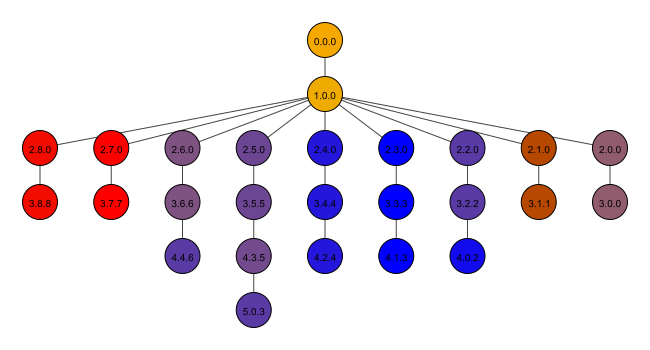

In [39]:
import igraph
root.color_by_value(df["building"].values, normalize=True)
g = root.as_igraph_graph()
vs = {
    "margin": 40,
    "bbox": (650, 350),
    "vertex_label": g.vs["name"],
    "vertex_label_size": 10,
    "vertex_size": 35,
    "vertex_label_dist": 0,
    "vertex_label_angle": 0,
    "layout": g.layout_reingold_tilford(root=[0])
}
igraph.plot(g, **vs)

In [56]:
def show_group_image(group, i=0):
    images = df["image"].iloc[list(group.rids)].unique()
    gdata = df.iloc[list(group.rids), :]
    img_name = images[i]
    gdata = gdata[gdata["image"] == img_name]

    img_path = DATA_DIR / img_name
    img = io.imread(str(img_path))
    mask = np.zeros(img.shape[:2], dtype=np.float32)
    cw, ch = CHIP_SHAPE

    for x, y in zip(gdata["x"].values, gdata["y"].values):
        x, y = (int(x), int(y))
        mask[y:(y+ch), x:(x+cw)] = 1

    overlay = pythd.image.overlay_mask(img, mask, image_alpha=0.6)

    pythd.image.plot_images((overlay,))

group = root.get_group_by_name("2.3.0")
images = df["image"].iloc[list(group.rids)].unique()
print(images)

['hurricane-florence_00000419_pre_disaster.png'
 'hurricane-matthew_00000133_pre_disaster.png'
 'hurricane-harvey_00000493_pre_disaster.png']


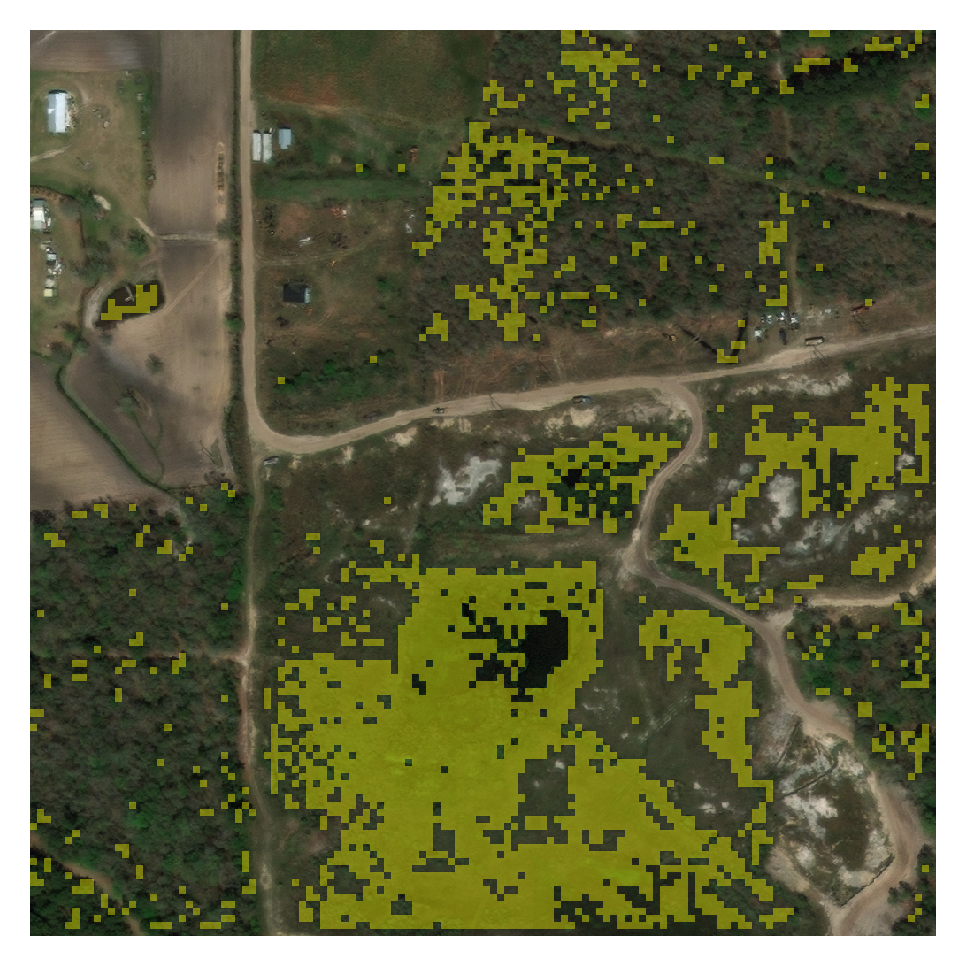

In [57]:
show_group_image(group, 0)

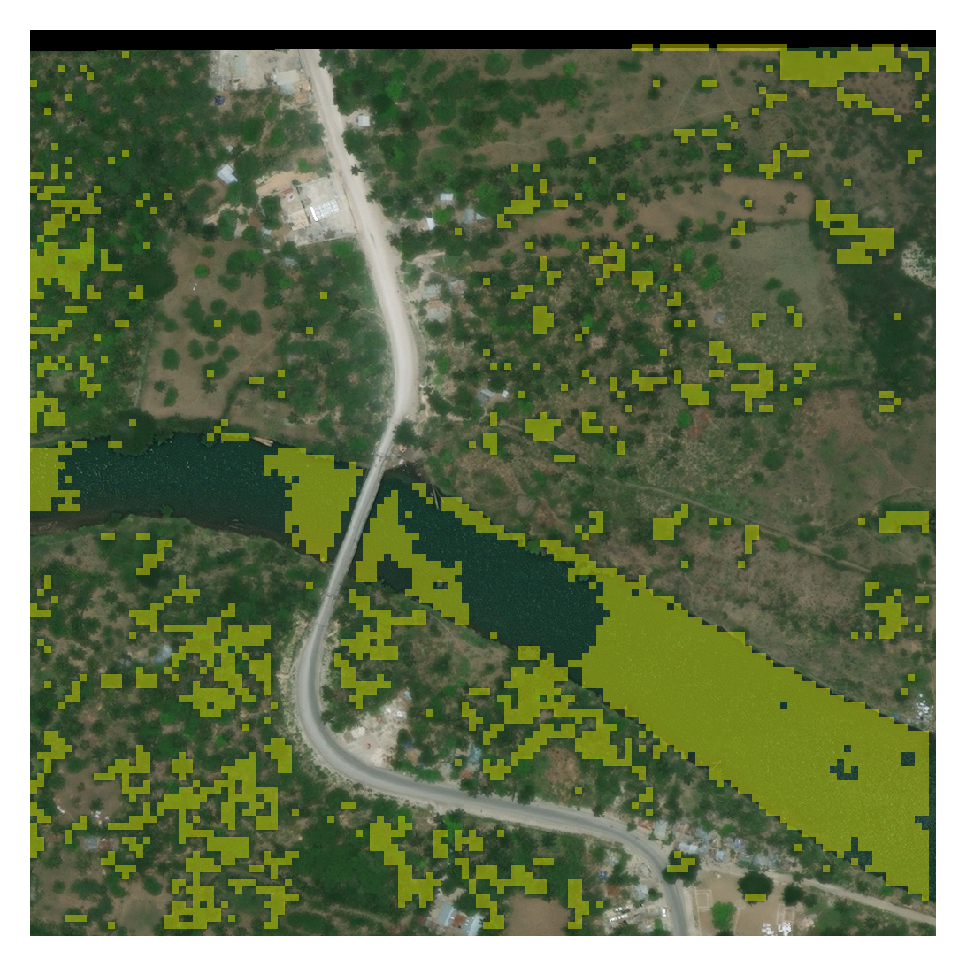

In [58]:
show_group_image(group, 1)

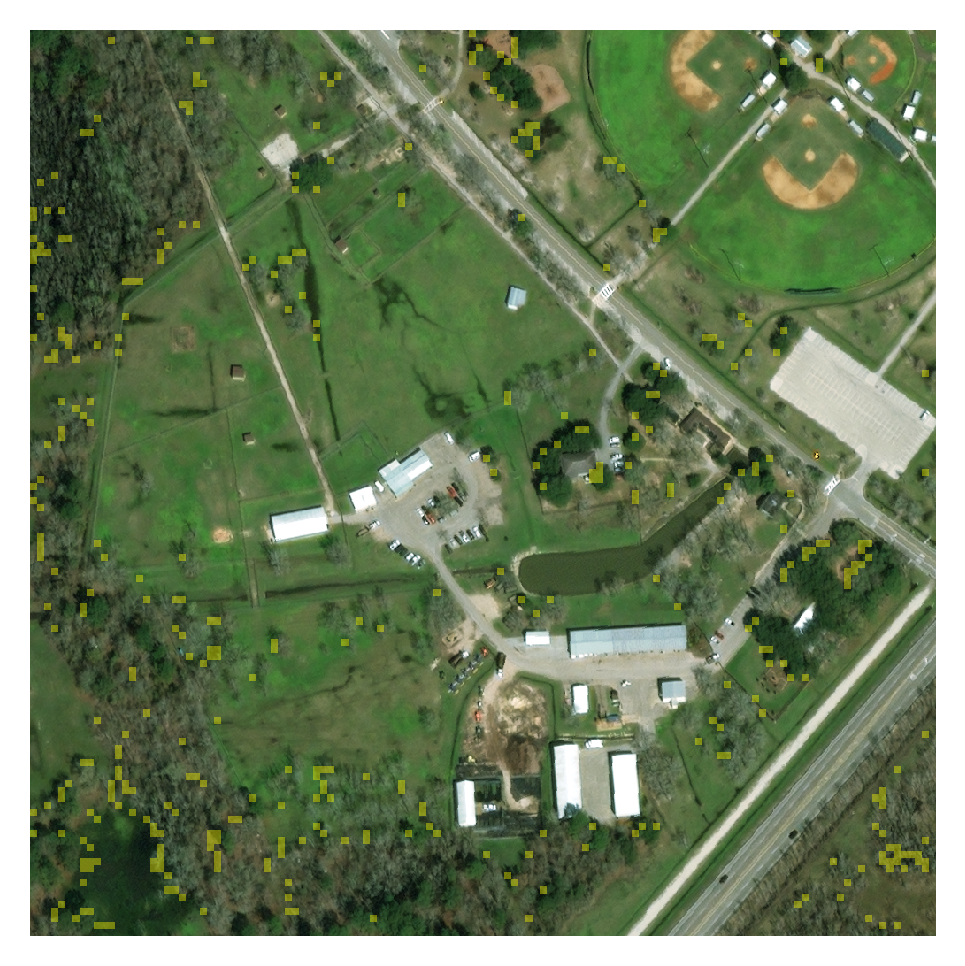

In [59]:
show_group_image(group, 2)

In [ ]:
show_group_image(group, 3)

In [ ]:
show_group_image(group, 4)

In [ ]:
show_group_image(group, 5)

In [ ]:
show_group_image(group, 6)